In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
!python --version
# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))


Python 3.11.5
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2


In [3]:
# Importation de la base de données
columns = ['target','id','Date','Origine','Name','text']
df =  pd.read_csv('training.csv', encoding="ISO-8859-1", names=columns)
df

,target,id,Date,Origine,Name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   target   1600000 non-null  int64 
 1   id       1600000 non-null  int64 
 2   Date     1600000 non-null  object
 3   Origine  1600000 non-null  object
 4   Name     1600000 non-null  object
 5   text     1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.isnull().sum()

target     0
id         0
Date       0
Origine    0
Name       0
text       0
dtype: int64

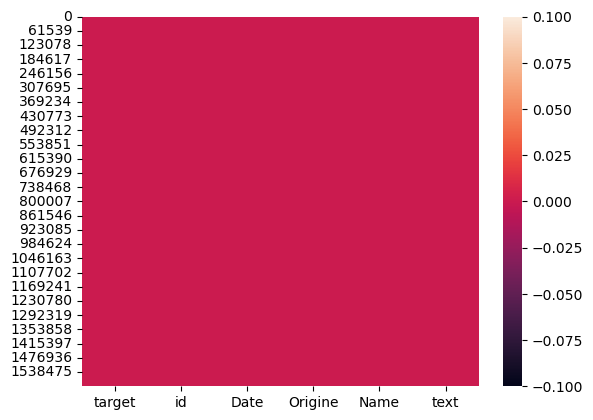

In [6]:
sns.heatmap(df.isnull());

In [7]:
df = df[['id','target','text']]
df

,id,target,text
0,1467810369,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,0,is upset that he can't update his Facebook by ...
2,1467810917,0,@Kenichan I dived many times for the ball. Man...
3,1467811184,0,my whole body feels itchy and like its on fire
4,1467811193,0,"@nationwideclass no, it's not behaving at all...."
...,...,...,...
1599995,2193601966,4,Just woke up. Having no school is the best fee...
1599996,2193601969,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,2193601991,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,2193602064,4,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
df.target.unique()

array([0, 4], dtype=int64)

In [9]:
df.loc[df['target'] == 4, 'target'] = 1
df.target.unique()

array([0, 1], dtype=int64)

In [10]:
df['target'].sample(20)

1360996    1
35233      0
941614     1
194275     0
288578     0
458479     0
1006152    1
298906     0
563363     0
1148026    1
1503443    1
379182     0
1400800    1
513792     0
1279596    1
497503     0
560870     0
477556     0
160350     0
1559614    1
Name: target, dtype: int64

In [11]:
category_count = df['target'].value_counts()
category_count

target
0    800000
1    800000
Name: count, dtype: int64

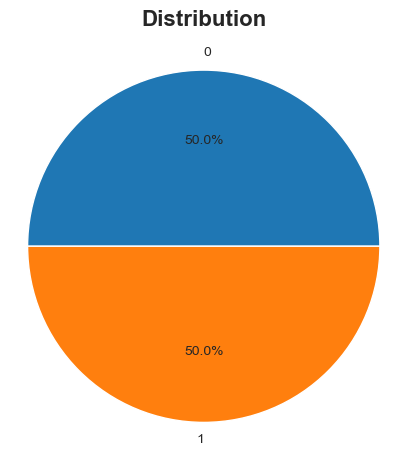

In [12]:
# La distribution par categorie
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%')
plt.title('Distribution',  fontsize=16, fontweight='bold', pad=20)
plt.axis('equal') 
plt.show()

#### La distribution est pafaitement équilibrée

In [13]:
# Sélection aléatoirement de 8000 tweets positifs
df_twit_pos = df[df['target'] == 1].sample(n=8000, random_state=42, replace=True)
# Sélection aléatoirement de 8000 tweets négatifs
df_twit_neg = df[df['target'] == 0].sample(n=8000, random_state=42, replace=True)
# Concaténer les tweets positifs et négatifs sélectionnés
df_twit = pd.concat([df_twit_pos, df_twit_neg])
# Réinitialiser les index
df = df_twit = df_twit.reset_index(drop=True)
df

,id,target,text
0,1754307909,1,"@V_J I haven't been sleeping well this wk, had..."
1,2065164963,1,okay off to sleep now
2,1770953638,1,@ashlili LIKE MEEEEEEEEE
3,1979880815,1,@Eva_Abreu Maybe we're bored..lol..I got plent...
4,1963116716,1,yay for atwin who had her baby boy Matthew Joh...
...,...,...,...
15995,2050614391,0,just realised I have no life. All I do is play...
15996,1832551419,0,my stupid phone does not text twitter.
15997,2261807429,0,hmph...text me...
15998,2032152065,0,"@lyneka dude, COBRA sucks. i remember when i h..."


In [14]:
df

,id,target,text
0,1754307909,1,"@V_J I haven't been sleeping well this wk, had..."
1,2065164963,1,okay off to sleep now
2,1770953638,1,@ashlili LIKE MEEEEEEEEE
3,1979880815,1,@Eva_Abreu Maybe we're bored..lol..I got plent...
4,1963116716,1,yay for atwin who had her baby boy Matthew Joh...
...,...,...,...
15995,2050614391,0,just realised I have no life. All I do is play...
15996,1832551419,0,my stupid phone does not text twitter.
15997,2261807429,0,hmph...text me...
15998,2032152065,0,"@lyneka dude, COBRA sucks. i remember when i h..."


In [15]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df["cleaned_text"]=df["text"].apply(cleaned_text)

In [17]:
df["cleaned_text"].head(10)

0    v j i haven t been sleeping well this wk had a...
1                               okay off to sleep now 
2                             ashlili like meeeeeeeee 
3    eva abreu maybe we re bored lol i got plenty o...
4    yay for atwin who had her baby boy matthew joh...
5    tungly haha thanks tung would rather not end u...
6    if you are a cute guy add follow me i ll do th...
7    drinking a smoothy nothing tastes better after...
8    i need the code to text facebook to the first ...
9    antandbecks hey could you guys play a song for...
Name: cleaned_text, dtype: object

In [18]:
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [19]:
df["cleaned_text"].head(10)

0    haven been sleeping well this nite woke early ...
1                                           okay sleep
2                              ashlili like meeeeeeeee
3    abreu maybe bored plenty sleep fell asleep wat...
4            atwin baby matthew john last night ounces
5    tungly haha thanks tung would rather with meal...
6                                     cute follow same
7    drinking smoothy nothing tastes better after r...
8                 need code text facebook first person
9    antandbecks could guys play song requested col...
Name: cleaned_text, dtype: object

In [20]:
stop=stopwords.words('english')
stop.append("also")
df["stop_cleaned_text"]=df["cleaned_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

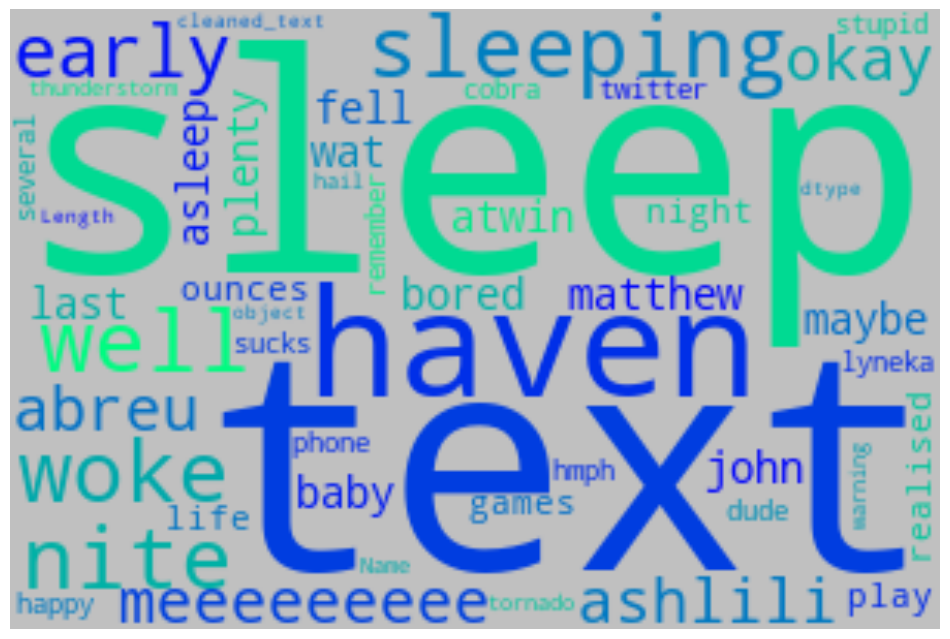

In [21]:
cloud=WordCloud(background_color='silver', colormap="winter", width=300,height=200).generate(str(df["cleaned_text"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [22]:
from nltk.tokenize import word_tokenize
df["tokenized"]=df["stop_cleaned_text"].apply(lambda x: nltk.word_tokenize(x))

In [23]:
df["tokenized"]

0        [sleeping, well, nite, woke, early, sleep, tim...
1                                            [okay, sleep]
2                              [ashlili, like, meeeeeeeee]
3        [abreu, maybe, bored, plenty, sleep, fell, asl...
4        [atwin, baby, matthew, john, last, night, ounces]
                               ...                        
15995                        [realised, life, play, games]
15996                       [stupid, phone, text, twitter]
15997                                         [hmph, text]
15998    [lyneka, dude, cobra, sucks, remember, several...
15999    [happy, thunderstorm, hail, tornado, warning, ...
Name: tokenized, Length: 16000, dtype: object

In [24]:
from nltk.stem import WordNetLemmatizer

In [25]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df["lemmatized"]=df["tokenized"].apply(lambda x: word_lemmatizer(x))
df["lemmatize_joined"]=df["lemmatized"].apply(lambda x: ' '.join(x))

In [26]:
df["lemmatize_joined"].head()

0          sleep well nite wake early sleep time crash
1                                           okay sleep
2                              ashlili like meeeeeeeee
3    abreu maybe bore plenty sleep fell asleep watc...
4            atwin baby matthew john last night ounces
Name: lemmatize_joined, dtype: object

In [27]:
df["lemmatize_joined"]

0              sleep well nite wake early sleep time crash
1                                               okay sleep
2                                  ashlili like meeeeeeeee
3        abreu maybe bore plenty sleep fell asleep watc...
4                atwin baby matthew john last night ounces
                               ...                        
15995                               realise life play game
15996                            stupid phone text twitter
15997                                            hmph text
15998    lyneka dude cobra suck remember several months...
15999    happy thunderstorm hail tornado warn roof pool...
Name: lemmatize_joined, Length: 16000, dtype: object

In [28]:
df.isnull().sum()

id                   0
target               0
text                 0
cleaned_text         0
stop_cleaned_text    0
tokenized            0
lemmatized           0
lemmatize_joined     0
dtype: int64

In [29]:
#df.to_csv('df1.csv', index=False)

In [30]:
df_samp = df.sample(10)

In [31]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['id']}\n"
    print( id_prod + ser["lemmatize_joined"]+ "..." +"\n\n")

: 2064071680
justkimu http twitpic photo...


: 1977222743
aaronsledge love love show...


: 2199270265
reason summer really make miss grandparents...


: 2006072792
tobyhenson target...


: 1794418703
alice cullen school soon...


: 2066555708
hmmmm think another attempt pancakes would birthday maybe like today...


: 1967812625
get ready watch little brother excite...


: 1793501767
wickedground people need repost...


: 1468088507
jreneebuchholz sometime like greek food well like food hehe...


: 2218887520
tarajean kind google main ingredients harmful dog hopefully...




###  Transformers

## word2vec

In [32]:
import multiprocessing
from gensim.models import FastText
from gensim.test.utils import common_texts 

In [33]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
warnings.filterwarnings(action='ignore')
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [34]:
dfsamp_vec =df.sample(1000)
dfsamp_vec[['target','lemmatize_joined']]

,target,lemmatize_joined
12375,0,ronisweigh trust want know heartbreaking
7553,1,uninitiated poutine russia president fry chip ...
853,1,jam buckley cassetteboy bloody apprentice watc...
1152,1,iantalbot little angelic total loveliness sarn...
5547,1,logiesssss watchin tuck
...,...,...
5792,1,bout ceviche
6533,1,thehypercube truly unbiased selection random d...
6295,1,jingudujing sound interest place
11768,0,damn leave blister alone hurt


In [36]:
sentenses = [word_tokenize(rev.lower()) for rev in df.lemmatize_joined]

In [61]:
model= FastText(sentenses, vector_size=100, window= 5, min_count=1, workers=4, seed = 4, sg=1  )

In [62]:
ftext = model.wv

In [ ]:
# Création d'une liste des phrases 
sentences = df.lemmatize_joined.tolist()
# Entraînement du modèle 
model = FastText(sentenses, vector_size=100, window= 5, min_count=1, workers=4, seed = 4, sg=1  )
# stocker les vecteurs de phrases
sentence_vectors = []
# Boucle des phrases
for sentence in sentences:
    sentence_vector = []
    # Parcourir chaque mot de la phrase et obtenir son vecteur
    for word in sentence:
        if word in model.wv:
            sentence_vector.append(model.wv[word])
    # Calculer le vecteur moyen de la phrase
    if sentence_vector:
        mean_vector = np.mean(sentence_vector, axis=0)
        sentence_vectors.append(mean_vector)

# Création d'un DataFrame à partir des vecteurs obtenus
df_sentence_vectors = pd.DataFrame(sentence_vectors, index=df['lemmatize_joined'],
                                   columns=[f'feature_{i+1}' for i in range(100)])

In [ ]:
from sklearn.manifold import TSNE

In [38]:
len(sentence_vectors)

999

In [57]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the word_vectors_df
tsne_result_wv = tsne.fit_transform(df_sentence_vectors)

# Create a new DataFrame for the t-SNE results
df_tsne_wv = pd.DataFrame(data = tsne_result_wv, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

In [58]:
df_tsne_wv

,TSNE1,TSNE2
0,-0.027021,-0.944104
1,1.015510,0.537327
2,-10.029070,-12.148231
3,12.548967,-1.489838
4,11.429246,-10.911567
...,...,...
993,28.629496,1.304003
994,-26.300419,-4.649808
995,12.070882,13.895082
996,14.018435,-3.158083


In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
dfsamp_vec['target_encod'] = label_encoder.fit_transform(dfsamp_vec['target'])

In [41]:
model1 = gensim.models.Word2Vec(dfsamp_vec.lemmatize_joined, min_count=1,
                                vector_size=100, window=5)

## BERT (Bidirectional Encoder Representations from Transformers)¶

In [33]:
df

,target,text,cleaned_text,stop_cleaned_text,tokenized,lemmatized,lemmatize_joined
0,1,"@V_J I haven't been sleeping well this wk, had...",haven been sleeping well this nite woke early ...,sleeping well nite woke early sleep time crash,"[sleeping, well, nite, woke, early, sleep, tim...","[sleep, well, nite, wake, early, sleep, time, ...",sleep well nite wake early sleep time crash
1,1,okay off to sleep now,okay sleep,okay sleep,"[okay, sleep]","[okay, sleep]",okay sleep
2,1,@ashlili LIKE MEEEEEEEEE,ashlili like meeeeeeeee,ashlili like meeeeeeeee,"[ashlili, like, meeeeeeeee]","[ashlili, like, meeeeeeeee]",ashlili like meeeeeeeee
3,1,@Eva_Abreu Maybe we're bored..lol..I got plent...,abreu maybe bored plenty sleep fell asleep wat...,abreu maybe bored plenty sleep fell asleep wat...,"[abreu, maybe, bored, plenty, sleep, fell, asl...","[abreu, maybe, bore, plenty, sleep, fell, asle...",abreu maybe bore plenty sleep fell asleep watc...
4,1,yay for atwin who had her baby boy Matthew Joh...,atwin baby matthew john last night ounces,atwin baby matthew john last night ounces,"[atwin, baby, matthew, john, last, night, ounces]","[atwin, baby, matthew, john, last, night, ounces]",atwin baby matthew john last night ounces
...,...,...,...,...,...,...,...
15995,0,just realised I have no life. All I do is play...,just realised have life play games,realised life play games,"[realised, life, play, games]","[realise, life, play, game]",realise life play game
15996,0,my stupid phone does not text twitter.,stupid phone does text twitter,stupid phone text twitter,"[stupid, phone, text, twitter]","[stupid, phone, text, twitter]",stupid phone text twitter
15997,0,hmph...text me...,hmph text,hmph text,"[hmph, text]","[hmph, text]",hmph text
15998,0,"@lyneka dude, COBRA sucks. i remember when i h...",lyneka dude cobra sucks remember when several ...,lyneka dude cobra sucks remember several month...,"[lyneka, dude, cobra, sucks, remember, several...","[lyneka, dude, cobra, suck, remember, several,...",lyneka dude cobra suck remember several months...


In [34]:
df.shape

(16000, 7)

In [35]:
df_lem_bert = df[['target','lemmatize_joined']]

In [36]:
df_lem_bert

,target,lemmatize_joined
0,1,sleep well nite wake early sleep time crash
1,1,okay sleep
2,1,ashlili like meeeeeeeee
3,1,abreu maybe bore plenty sleep fell asleep watc...
4,1,atwin baby matthew john last night ounces
...,...,...
15995,0,realise life play game
15996,0,stupid phone text twitter
15997,0,hmph text
15998,0,lyneka dude cobra suck remember several months...


In [50]:
import torch
from transformers import BertTokenizer, BertModel

In [51]:
# Setting the device to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Loading the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
# Setting the model to evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [52]:
# Fonction pour encoder le texte à l'aide du tokenizer
def get_bert_embeddings(text):
    encoded_input = tokenizer(text, padding = True, truncation = True, return_tensors = 'pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask = attention_mask)
        
    # Calculating the mean embedding of the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim = 1)
    
    # Converting the embeddings to a list and return
    return embeddings.tolist()[0]

In [53]:
# Applying the function to the lemmatized text
df_bert = df_lem_bert['lemmatize_joined'].apply(get_bert_embeddings)

In [54]:
df_bert_fin = pd.DataFrame(df_bert)

In [55]:
df_bert_fin.head()

,lemmatize_joined
0,"[0.2781204581260681, -0.28868958353996277, -0...."
1,"[-0.1907552182674408, -0.0641854777932167, 1.0..."
2,"[0.18790605664253235, 0.11662247776985168, -0...."
3,"[-0.14786435663700104, 0.296294242143631, 0.53..."
4,"[-0.07425256818532944, 0.2586651146411896, 0.5..."


In [56]:
# Transforming to a list
df_bert_list = pd.DataFrame(df_bert_fin['lemmatize_joined'].to_list())

# Splitting the values within the columns using comma delimiter
df_bert_conc = pd.concat([df_bert_list[col].astype(str).str.split(',', expand=True) for col in df_bert_list.columns], axis=1)

# Renaming columns starting from 0
df_bert_conc.columns = [str(i) for i in range(len(df_bert_conc.columns))]

# Displaying the resulting DataFrame with separate columns
df_bert_conc

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.2781204581260681,-0.28868958353996277,-0.2482675313949585,-0.016369745135307312,-0.1387195736169815,-0.16143035888671875,0.08039704710245132,0.0900207906961441,-0.19825533032417297,-0.021962087601423264,...,0.28309711813926697,-0.22112596035003662,-0.321345716714859,0.22195854783058167,0.5167633891105652,-0.16522133350372314,-0.1857055425643921,0.011175906285643578,-0.41066062450408936,-0.05158381536602974
1,-0.1907552182674408,-0.0641854777932167,1.072218894958496,-0.11467604339122772,0.23835435509681702,-0.16264498233795166,0.2925689220428467,0.17154651880264282,-0.12332691997289658,-0.2390454262495041,...,-0.371511310338974,-0.3356364667415619,-0.17679166793823242,-0.2802566885948181,-0.2653418183326721,0.04359041899442673,-0.3026844263076782,-0.05793998762965202,-0.11533218622207642,-0.025720875710248947
2,0.18790605664253235,0.11662247776985168,-0.002540455898270011,-0.10674149543046951,0.18717144429683685,0.026825739070773125,0.25000351667404175,-0.037581488490104675,-0.30526116490364075,-0.27834904193878174,...,-0.12849213182926178,-0.2336745262145996,0.08741506934165955,0.026777837425470352,-0.1766154170036316,-0.12601473927497864,-0.296999454498291,-0.396884948015213,-0.01287741120904684,0.013231641612946987
3,-0.14786435663700104,0.296294242143631,0.5362812876701355,-0.26832523941993713,-0.22662831842899323,-0.5846085548400879,0.43457818031311035,0.6211094856262207,0.3461228013038635,-0.33489739894866943,...,-0.2451709806919098,-0.04568008705973625,0.013601395301520824,0.31948012113571167,-0.09118293970823288,-0.523470938205719,0.25333645939826965,-0.5500847101211548,-0.08944904804229736,-0.2713679373264313
4,-0.07425256818532944,0.2586651146411896,0.5398642420768738,-0.09298637509346008,-0.22453705966472626,-0.08599819242954254,0.3214899003505707,0.31665876507759094,-0.23345929384231567,-0.27946341037750244,...,-0.10943792760372162,-0.30229225754737854,-0.13021129369735718,-0.2629278600215912,-0.06605322659015656,0.1257358342409134,-0.21051384508609772,-0.34139758348464966,0.23198598623275757,-0.1750543713569641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.0490780733525753,-0.16400395333766937,0.767024576663971,0.15189005434513092,0.3342684805393219,-0.17913512885570526,0.5661215782165527,0.36771565675735474,-0.16795973479747772,-0.23626628518104553,...,-0.06572210788726807,-0.27863919734954834,0.02361510507762432,-0.2878853678703308,0.04792247712612152,-0.0387645848095417,-0.1360667496919632,-0.3850099742412567,-0.2176901251077652,-0.4382522404193878
15996,0.41073814034461975,0.045946743339300156,0.34555575251579285,0.3607289493083954,0.08875580877065659,-0.3098725378513336,0.07145975530147552,0.34195050597190857,0.027623804286122322,-0.12342092394828796,...,0.28049784898757935,-0.1780967116355896,0.22998066246509552,-0.16886864602565765,-0.3472166955471039,0.05122794583439827,-0.13292454183101654,-0.21644146740436554,0.1702142208814621,-0.010385234840214252
15997,0.07475661486387253,0.005843501538038254,0.5124210715293884,0.16425882279872894,0.22277843952178955,0.1746305525302887,-0.03556521609425545,0.12540408968925476,-0.10791034996509552,-0.35779061913490295,...,0.27682414650917053,-0.13143324851989746,-0.013914020732045174,-0.05551503598690033,0.18812154233455658,0.27830392122268677,-0.07031301409006119,-0.24269744753837585,0.14706917107105255,-0.10874303430318832
15998,0.4660075902938843,-0.016063537448644638,0.05090412124991417,0.07599863409996033,0.03855693340301514,-0.10710017383098602,0.30245548486709595,0.5348731875419617,0.1744115799665451,-0.20094992220401764,...,0.35594630241394043,-0.5458841323852539,0.04790744557976723,-0.14368411898612976,-0.11543115973472595,-0.006667569279670715,-0.05769454687833786,-0.2629435062408447,-0.004943042993545532,0.035115160048007965


In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

In [58]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_bert = tsne.fit_transform(df_bert_conc)

# Creating a new df for the results
df_tsne_bert = pd.DataFrame(data = tsne_result_bert, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

In [59]:
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df_lem_bert['Target_encod'] = label_encoder.fit_transform(df_lem_bert['target'])

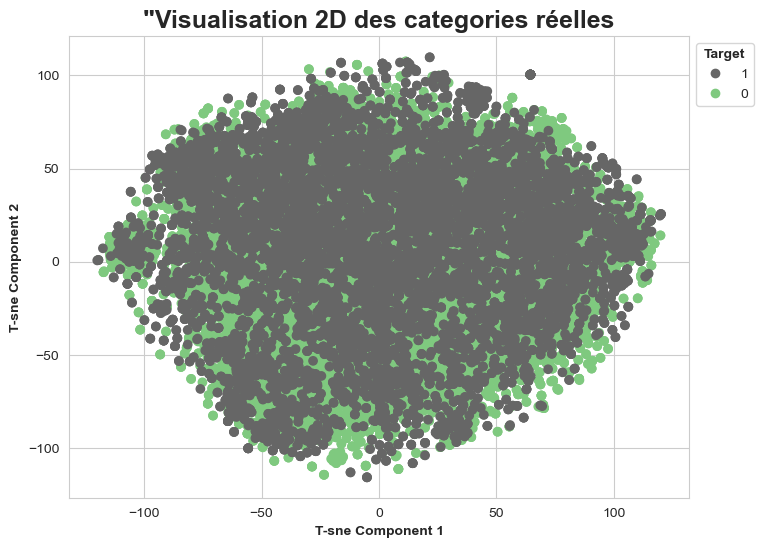

In [60]:
# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_tsne_bert['TSNE1'], df_tsne_bert['TSNE2'], c=df_lem_bert['Target_encod'], cmap='Accent_r')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_lem_bert['Target_encod'].unique(), title='Target', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight = 'bold')
plt.ylabel('T-sne Component 2', fontweight = 'bold')
plt.title('"Visualisation 2D des categories réelles', fontweight ='bold', fontsize=18)
plt.show()

In [61]:
# NLP
from textblob import TextBlob
from sklearn.feature_extraction import text
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Machine Learning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:
# Getting a count of words from the documents
# Ngram_range is set to 1,2 - meaning either single or two word combination will be extracted
tokenizer = TweetTokenizer()
cvec = CountVectorizer(ngram_range=(1,2), tokenizer=tokenizer.tokenize)
full_text = list(df["lemmatize_joined"].values)
cvec.fit(full_text)
# Getting the total n-gram count
len(cvec.vocabulary_)

111023

In [62]:
train_vectorized = cvec.transform(df["lemmatize_joined"])

# Getting the matrix shape
print('sparse matrix shape:', train_vectorized.shape)

# Getting the nonzero count
print('nonzero count:', train_vectorized.nnz)

# Getting sparsity %
print('sparsity: %.2f%%' % (100.0 * train_vectorized.nnz / (train_vectorized.shape[0] * train_vectorized.shape[1])))

sparse matrix shape: (20000, 111023)
nonzero count: 226617
sparsity: 0.01%


In [63]:
test_vectorized = cvec.transform(df["lemmatize_joined"])

# Getting the matrix shape
print('sparse matrix shape:', test_vectorized.shape)

# Getting the nonzero count
print('nonzero count:', test_vectorized.nnz)

# Getting sparsity %
print('sparsity: %.2f%%' % (100.0 * test_vectorized.nnz / (test_vectorized.shape[0] * test_vectorized.shape[1])))

sparse matrix shape: (20000, 111023)
nonzero count: 226617
sparsity: 0.01%


In [64]:
test_vectorized 

<20000x111023 sparse matrix of type '<class 'numpy.int64'>'
	with 226617 stored elements in Compressed Sparse Row format>

In [65]:
transformer = TfidfTransformer()

# Fitting and transforming n-grams
train_tdidf = transformer.fit_transform(train_vectorized)
test_tdidf = transformer.fit_transform(test_vectorized)

In [66]:
# Create X & y variables for Machine Learning
X_train = train_tdidf
y_train = df['target']

X_test = test_tdidf

In [67]:
def model(mod, model_name, X_train, y_train):
    
    # Fitting model
    mod.fit(X_train, y_train)
    
    # Print model name
    print(model_name)
    
    # Compute 5-fold cross validation: Accuracy
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)

    # Compute 5-fold prediction on training set
    predictions = cross_val_predict(mod, X_train, y_train, cv = 5)

    # Return accuracy score to 3dp
    print("Accuracy:", round(acc.mean(), 3))
 
    # Compute confusion matrix
    cm = confusion_matrix(predictions, y_train)
    
    # Print confusion matrix
    print("Confusion Matrix:  \n", cm)

    # Print classification report
    print("Classification Report \n", classification_report(predictions, y_train))

## USE (Universal Sentence Encoder)

In [62]:
df_use= df[['lemmatize_joined','target']]
df_use = df_use.sample(2000)

In [63]:
df_use

,lemmatize_joined,target
692,beebubble purdy,1
12050,spend golf roadie church praise band suspect w...,0
2607,liezje ingekuik miss,1
15423,plan get little tanner swim sunburn pretty sur...,0
8070,welp iphone sorta die bottom button totally un...,0
...,...,...
14271,supearlative understand headache deliver heada...,0
7657,gcgreg definitely greg glad read rant,1
129,do read angels demons excite watch movie,1
6135,iremember shotgun dial among,1


In [64]:
import tensorflow as tf

In [65]:
import tensorflow_hub as hub

In [66]:
#Converting each sequence of words into a single string
sentences = df_use['lemmatize_joined'].apply(' '.join).values.astype('U')

# Getting and loading the URL for the USE model
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
use_model = hub.load(module_url)

# Creating a KerasLayer fro mthe loaded model
embedding_fn = hub.KerasLayer(use_model, input_shape=[], dtype=tf.string, trainable=False)

# Creating a sequential model with the embedding layer
embedding_model = tf.keras.Sequential([embedding_fn])

# Converting the sentences to a numpy array
sentences_array = np.array(sentences, dtype=object) 

# Generating the sentences with the embedding model
embeddings = embedding_model.predict(sentences_array)

# Transforming to df
df_embed = pd.DataFrame(embeddings)

63/63 [==============================] - 146s 2s/step


In [68]:
df_embed

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.052731,0.013528,-0.023628,0.010993,-0.020646,-0.055309,-0.064433,-0.035137,0.006861,-0.007601,...,-0.040044,-0.016022,-0.023192,-0.020459,-0.040759,-0.016452,0.002841,-0.011804,-0.048126,0.009864
1,-0.043960,-0.012593,-0.000668,0.035555,-0.032502,-0.016376,-0.023391,-0.058556,0.003555,-0.012444,...,-0.035890,-0.025279,0.019310,-0.016818,-0.038986,-0.070140,0.021475,-0.004458,0.012033,0.002044
2,-0.006344,0.001007,-0.021479,0.019773,-0.040241,0.013534,0.020980,-0.024027,-0.002207,-0.015262,...,-0.036949,0.014319,-0.012320,-0.004655,-0.026023,-0.079400,-0.003414,-0.010755,0.020875,0.006964
3,-0.048386,-0.007672,-0.027242,0.039591,-0.020802,-0.012779,-0.010078,-0.053397,0.029082,-0.026996,...,-0.029968,-0.020093,0.030200,-0.011210,-0.040318,-0.086881,0.019084,0.006089,0.032187,-0.009190
4,-0.069653,-0.016500,-0.023914,0.040185,-0.006658,-0.001570,-0.005148,-0.054508,0.029425,-0.020248,...,-0.018326,-0.013418,0.035940,-0.016204,-0.053411,-0.081766,0.019896,0.011522,0.031142,-0.014657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.025599,-0.000467,-0.008718,0.022224,-0.033096,-0.007348,-0.010461,-0.044758,0.003921,-0.022737,...,-0.024286,-0.001613,0.032658,-0.017512,-0.039906,-0.089475,0.011270,0.017716,0.024971,-0.007116
1996,-0.033032,-0.003788,-0.013889,0.007179,-0.024108,0.013309,-0.026475,-0.020750,0.000433,0.001407,...,-0.015120,0.016041,-0.004495,-0.014072,-0.030089,-0.090506,0.002234,-0.041696,-0.026170,0.032027
1997,-0.046764,-0.010521,-0.006942,0.039957,-0.003712,-0.003933,0.002391,-0.047896,0.014432,-0.012444,...,-0.027200,-0.008843,0.017867,-0.026698,-0.046964,-0.093548,0.008529,-0.005983,0.002231,0.000207
1998,-0.035385,0.011943,-0.022023,0.034420,-0.043223,-0.018396,-0.021058,-0.024985,0.031184,-0.004303,...,-0.059283,-0.030310,0.001037,-0.019489,-0.040342,-0.095678,0.006972,-0.024213,-0.009022,0.012053


In [69]:
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidfdf_embed
tsne_result_use = tsne.fit_transform(df_embed)

# Create a new DataFrame for the t-SNE results
df_tsne_use = pd.DataFrame(data = tsne_result_use, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

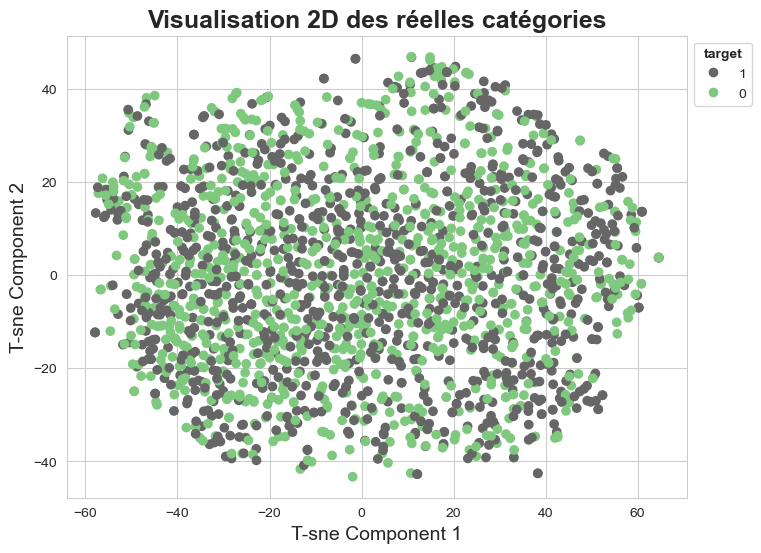

In [70]:
# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_tsne_use['TSNE1'], df_tsne_use['TSNE2'], c=df_use['target'], cmap='Accent_r')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_use['target'].unique(), title='target', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontsize=14)
plt.ylabel('T-sne Component 2', fontsize=14)
plt.title('Visualisation 2D des réelles catégories', fontweight ='bold', fontsize=18)
plt.show()

## Modelisation

In [37]:
from joblib import dump 
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

In [38]:
df["lemmatize_joined"]

0              sleep well nite wake early sleep time crash
1                                               okay sleep
2                                  ashlili like meeeeeeeee
3        abreu maybe bore plenty sleep fell asleep watc...
4                atwin baby matthew john last night ounces
                               ...                        
15995                               realise life play game
15996                            stupid phone text twitter
15997                                            hmph text
15998    lyneka dude cobra suck remember several months...
15999    happy thunderstorm hail tornado warn roof pool...
Name: lemmatize_joined, Length: 16000, dtype: object

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()
# Appliquer le vectoriseur sur la colonne 'texte_nettoye'
features = vectorizer.fit_transform(df["lemmatize_joined"])
# Convertir les caractéristiques en une représentation de matrice creuse
features = features.toarray()
# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", features.shape)

Dimensions de la matrice de caractéristiques : (16000, 20425)


In [40]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(features, df['target'], test_size=0.2, stratify=df['target'], random_state=42)

### LogisticRegression

In [41]:
# Construire le modèle de régression logistique
reg_model = LogisticRegression()
reg_model.fit(X_train, y_train)

# Prédire les probabilités pour les ensembles d'entraînement et de test
y_train_pred = reg_model.predict_proba(X_train)[:, 1]
y_test_pred = reg_model.predict_proba(X_test)[:, 1]


In [42]:
print(reg_model.score(X_train, y_train ))
print(reg_model.score(X_test, y_test ))

0.860546875
0.7271875


In [43]:
y_pred = reg_model.predict(X_test)

In [44]:
accuracy_score(y_test, y_pred)

0.7271875

In [45]:
dump(reg_model, 'reg_model.joblib')

['reg_model.joblib']

In [46]:
# Calculer les valeurs de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculer l'AUC pour les ensembles d'entraînement et de test
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

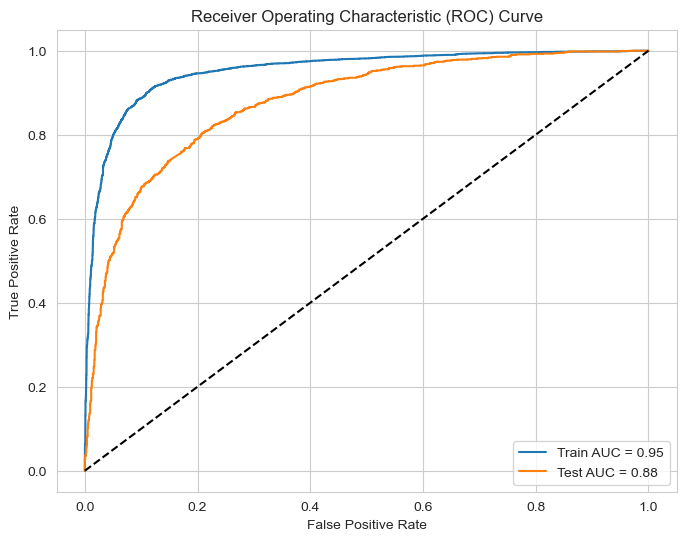

In [81]:
# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test AUC = {:.2f}'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [82]:
# Calculer les performances sur les ensembles d'entraînement et de test
train_accuracy = accuracy_score(y_train, reg_model.predict(X_train))
train_precision = precision_score(y_train, reg_model.predict(X_train))
train_recall = recall_score(y_train, reg_model.predict(X_train))
train_f1 = f1_score(y_train, reg_model.predict(X_train))
test_accuracy = accuracy_score(y_test, reg_model.predict(X_test))
test_precision = precision_score(y_test, reg_model.predict(X_test))
test_recall = recall_score(y_test, reg_model.predict(X_test))
test_f1 = f1_score(y_test, reg_model.predict(X_test))

# Créer un tableau des performances
performance_table = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

print(performance_table)

  Performance     Train      Test
0    Accuracy  0.894844  0.797500
1   Precision  0.890210  0.791667
2      Recall  0.900781  0.807500
3    F1 Score  0.895464  0.799505


                               -----------------------------------------------------

## Deep Learning

In [124]:
from sklearn.model_selection import train_test_split
import keras.preprocessing.sequence 
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras import layers
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, Flatten, Dense


In [125]:

X = df['lemmatize_joined'].values
y = df['target'].values


In [126]:

X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.6, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

In [127]:
X_train.shape, X_val.shape, X_test.shape

((9600,), (3840,), (2560,))

In [128]:
X_train

array(['bloody servers work least hours want home',
       'ebonistephae nope glass sunny',
       'rave classics lownoise theo ravers nature music', ...,
       'deadinthescene sorry please disappoint',
       'troyahyo know name mean italian phonetic traslation',
       'ummm well power ever want remove maul beyond'], dtype=object)

In [129]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
Xcnn_train = tokenizer.texts_to_sequences(X_train)
Xcnn_test = tokenizer.texts_to_sequences(X_test)
Xcnn_val = tokenizer.texts_to_sequences(X_val)
vocab_size = len(tokenizer.word_index) + 1  
print(X_train[1])
print(Xcnn_train[1]) 

ebonistephae nope glass sunny
[3994, 675, 1047, 271]


In [130]:
Xcnn_train

[[730, 1580, 1, 207, 106, 9, 22],
 [3994, 675, 1047, 271],
 [2535, 3995, 3996, 3997, 3998, 2536, 182],
 [3999, 435, 101, 2537, 4000, 788, 489, 4001],
 [13, 1968, 78, 1581, 4002, 286, 23, 4003],
 [1048, 11, 202],
 [4004, 139, 4, 15, 1349, 937, 21, 1582, 316, 371, 357],
 [4005, 143, 203],
 [261, 4006, 162, 938],
 [4007, 1350, 4008, 4009],
 [4010, 53, 24, 789, 1, 297],
 [2538, 4011, 43],
 [286, 1351, 52, 228, 344, 114, 94, 38, 1969, 939, 97],
 [22, 83, 4012, 3],
 [150, 2539, 247, 117, 1049, 4013, 1168, 345],
 [4014, 544, 223, 139, 2, 39],
 [102, 18, 512, 229, 152, 731, 4015, 940, 732, 2540],
 [4016, 101, 606, 28, 6, 28, 606],
 [23, 98, 71, 158, 1583, 12, 849, 676],
 [607, 7, 26, 111, 134, 4017, 20, 62, 5, 38],
 [4018, 45, 463, 25, 27, 108],
 [4019, 14, 1169, 1970, 114, 153, 29],
 [4020, 416, 637, 12, 172, 114],
 [4021, 36, 112],
 [24, 4022, 4023],
 [4024, 1, 2541, 1050],
 [70, 4025, 4026],
 [4027],
 [4028, 55, 580, 1584, 1585],
 [4029, 129, 312, 15],
 [111, 1971, 286, 3, 13, 2542, 40],
 [

In [131]:
maxlen = 100
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
Xcnn_val = pad_sequences(Xcnn_val, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

[ 730 1580    1  207  106    9   22    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [132]:
num_words=5000
top_words = 7000
embedding_dim = 200
maxlen = 100

##  Modèle_1

In [133]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [134]:
maxlen = 100
model0 = Sequential([
    Embedding(vocab_size, 8, input_length=maxlen),
   Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
  Dense(10, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [135]:
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model0.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 100, 8)            113240    
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 128)           5248      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_32 (Dense)            (None, 10)                1290      
                                                                 
 dense_33 (Dense)            (None, 1)                 11        
                                                                 
Total params: 119,789
Trainable params: 119,789
Non-trainable params: 0
_______________________________________________

In [136]:
history = model0.fit(Xcnn_train,y_train,
                     epochs=10,
                     verbose=True,
                     validation_data=(Xcnn_test, y_test),
                     batch_size=10)

Epoch 1/10
960/960 [==============================] - 9s 8ms/step - loss: 0.6372 - acc: 0.6452 - val_loss: 0.5744 - val_acc: 0.7051
Epoch 2/10
960/960 [==============================] - 7s 8ms/step - loss: 0.4933 - acc: 0.7718 - val_loss: 0.5732 - val_acc: 0.7078
Epoch 3/10
960/960 [==============================] - 7s 7ms/step - loss: 0.3854 - acc: 0.8289 - val_loss: 0.6448 - val_acc: 0.7016
Epoch 4/10
960/960 [==============================] - 7s 7ms/step - loss: 0.2968 - acc: 0.8771 - val_loss: 0.7309 - val_acc: 0.6891
Epoch 5/10
960/960 [==============================] - 7s 8ms/step - loss: 0.2243 - acc: 0.9103 - val_loss: 0.8853 - val_acc: 0.6750
Epoch 6/10
960/960 [==============================] - 7s 7ms/step - loss: 0.1770 - acc: 0.9306 - val_loss: 0.9494 - val_acc: 0.6809
Epoch 7/10
960/960 [==============================] - 7s 8ms/step - loss: 0.1451 - acc: 0.9419 - val_loss: 1.1057 - val_acc: 0.6754
Epoch 8/10
960/960 [==============================] - 8s 8ms/step - loss: 0.

In [79]:
loss, accuracy = model0.evaluate(Xcnn_test, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

loss, accuracy = model.evaluate(Xcnn_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xcnn_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

80/80 [==============================] - 1s 5ms/step - loss: 2.6737 - acc: 0.6574
Testing Accuracy is 65.7421886920929 
300/300 [==============================] - 4s 12ms/step - loss: 0.0488 - accuracy: 0.9754
Training Accuracy: 0.9754
120/120 [==============================] - 1s 10ms/step - loss: 1.7797 - accuracy: 0.6687
Validation Accuracy:  0.6687


In [140]:
loss, accuracy = model0.evaluate(Xcnn_test, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

loss, accuracy = model.evaluate(Xcnn_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xcnn_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

80/80 [==============================] - 0s 5ms/step - loss: 0.7334 - acc: 0.7957
Testing Accuracy is 79.5703113079071 
300/300 [==============================] - 3s 11ms/step - loss: 0.0373 - accuracy: 0.9812
Training Accuracy: 0.9812
120/120 [==============================] - 1s 11ms/step - loss: 1.1011 - accuracy: 0.7958
Validation Accuracy:  0.7958


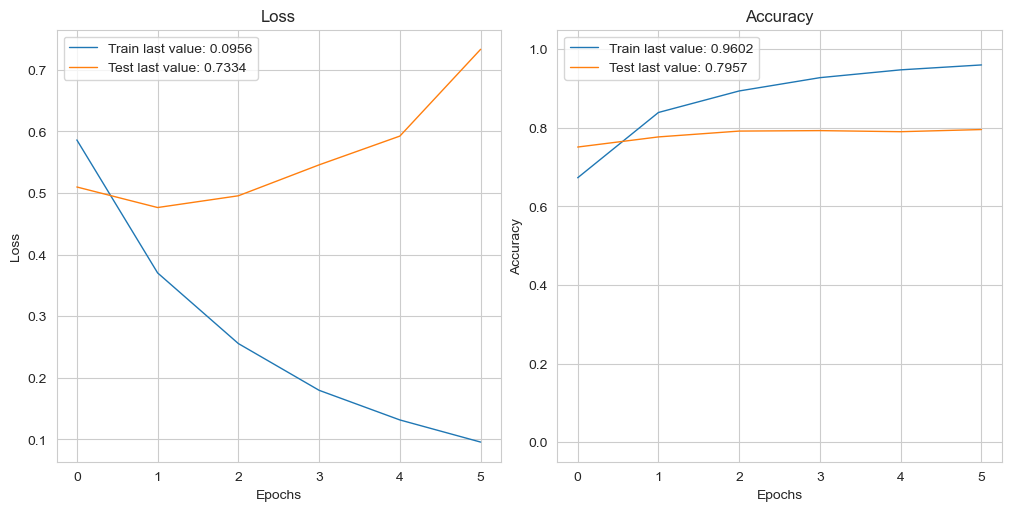

In [141]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

## Modèle_2  avec integration de GloVe (intégrations de mots pré-entraînées)

In [142]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_size = 5000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [143]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [144]:
# pad documents to a max length of 100 words
max_length = 100
padding_type = "post"
trunction_type="post"
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,
                       truncating=trunction_type)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)
X_val_padded = pad_sequences(X_val_sequences,maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)

In [145]:
X_val_padded

array([[  44, 4470,  114, ...,    0,    0,    0],
       [ 146,   29,  980, ...,    0,    0,    0],
       [ 368,  218, 4280, ...,    0,    0,    0],
       ...,
       [  11,  168,  598, ...,    0,    0,    0],
       [ 171,  401,    0, ...,    0,    0,    0],
       [   1,   15,  129, ...,    0,    0,    0]])

In [ ]:
labels = df['target']
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(df["lemmatize_joined"])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(df["lemmatize_joined"])
print(encoded_docs)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

In [146]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [99]:
embeddings_index.get("paper")

array([-0.85034  ,  0.33358  , -0.65889  , -0.49871  ,  0.36585  ,
       -0.19245  ,  0.25658  , -0.053408 ,  0.31474  ,  0.2443   ,
        0.29337  , -0.44917  ,  0.15175  ,  0.39314  , -0.31786  ,
        0.060525 ,  0.81775  , -0.38847  ,  0.76761  , -1.1041   ,
       -0.1544   ,  0.31655  , -0.37238  , -0.11485  ,  0.51635  ,
       -0.39289  ,  0.16301  , -0.2532   , -0.50976  ,  0.15201  ,
        0.27808  ,  0.52522  , -0.38815  , -0.3472   , -0.61818  ,
        0.17022  ,  0.12251  , -0.24191  , -0.38877  , -0.53176  ,
       -0.46987  , -0.70502  , -0.62126  , -0.38689  , -0.85637  ,
       -0.41003  , -0.47487  , -0.21083  , -0.81338  , -0.52398  ,
        0.49894  ,  0.37909  ,  0.55428  ,  1.123    , -0.42121  ,
       -1.5674   , -0.56892  ,  0.40819  ,  1.7949   ,  0.16856  ,
       -0.0029332,  0.28786  , -0.90088  , -0.094214 ,  0.79993  ,
       -0.39096  ,  0.76286  ,  0.71307  ,  0.13194  , -0.40756  ,
       -0.18687  ,  0.89562  ,  0.46867  , -0.0028801,  0.0253

In [148]:
t = Tokenizer()

In [149]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [150]:
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

In [151]:
model_c = Sequential([
    embedding_layer,
  Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
  Dense(10, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [152]:
model_c.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [153]:
history = model_c.fit(X_train_padded, y_train, epochs=6, validation_data=(X_test_padded, y_test))

Epoch 1/6
300/300 [==============================] - 17s 51ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/6
300/300 [==============================] - 15s 51ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/6
300/300 [==============================] - 16s 53ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/6
300/300 [==============================] - 18s 59ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/6
300/300 [==============================] - 17s 57ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/6
300/300 [==============================] - 16s 53ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5000


In [107]:
loss, accuracy = model_c.evaluate(X_test_padded,y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

125/125 [==============================] - 3s 22ms/step - loss: 0.7714 - accuracy: 0.6465
Testing Accuracy is 64.64999914169312 


In [154]:
loss, accuracy = model_c.evaluate(X_test_padded, y_test, verbose=True)
print('Testing Accuracy is {} '.format(accuracy))

loss, accuracy = model_c.evaluate(X_train_padded, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_c.evaluate(X_val_padded, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

80/80 [==============================] - 2s 23ms/step - loss: 0.6931 - accuracy: 0.5000
Testing Accuracy is 0.5 
300/300 [==============================] - 6s 21ms/step - loss: 0.6932 - accuracy: 0.5000
Training Accuracy: 0.5000
120/120 [==============================] - 3s 22ms/step - loss: 0.6931 - accuracy: 0.5000
Validation Accuracy:  0.5000


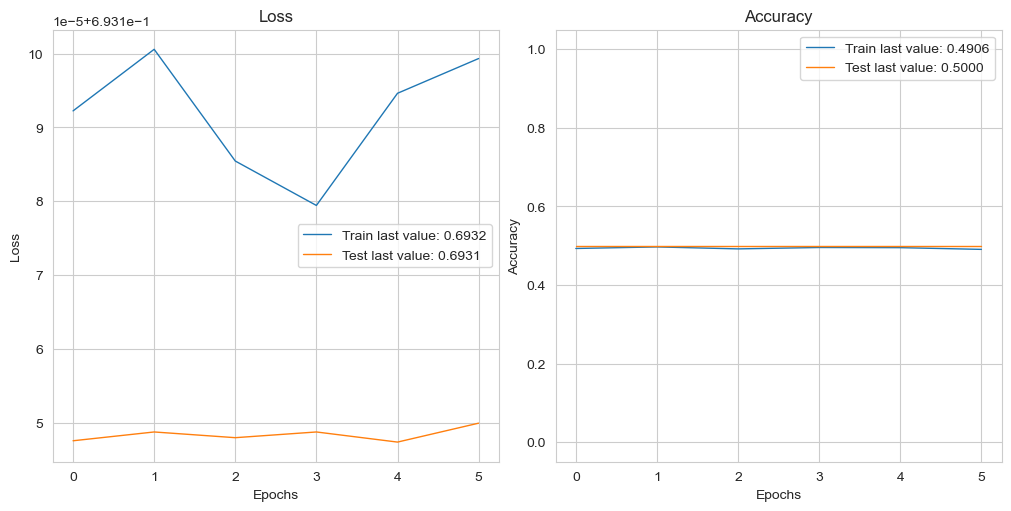

In [155]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()

## Modèle_3 avec  LSTM

In [82]:
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.6, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

In [83]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import pad_sequences
max_words = 5000

In [84]:

# Tokenization and Padding

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df["lemmatize_joined"])
#sequences = tokenizer.texts_to_sequences(df["lemmatize_joined"])
#X = pad_sequences(sequences, maxlen=100)  # Adjust maxlen as needed

X = tokenizer.texts_to_sequences(df["lemmatize_joined"].values)
X = pad_sequences(X, maxlen=100)

In [85]:
tokenizer = Tokenizer(nb_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(df["lemmatize_joined"].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(df["lemmatize_joined"].values)
X = pad_sequences(X)

In [118]:
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state =42)

In [110]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = X.shape[1]))
#model.add(LSTM(50, activation='relu',return_sequences=True))
#model.add(LSTM(50, activation='relu'))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'mse', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 17, 128)           320000    
                                                                 
 lstm_12 (LSTM)              (None, 200)               263200    
                                                                 
 dense_31 (Dense)            (None, 1)                 201       
                                                                 
Total params: 583,401
Trainable params: 583,401
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
y_train.shape, X_train.shape

((12800,), (12800, 17))

In [120]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
400/400 [==============================] - 29s 72ms/step - loss: 0.0605 - accuracy: 0.9238
Epoch 2/10
400/400 [==============================] - 28s 70ms/step - loss: 0.0562 - accuracy: 0.9285
Epoch 3/10
400/400 [==============================] - 30s 75ms/step - loss: 0.0534 - accuracy: 0.9305
Epoch 4/10
400/400 [==============================] - 38s 95ms/step - loss: 0.0487 - accuracy: 0.9386
Epoch 5/10
400/400 [==============================] - 34s 85ms/step - loss: 0.0463 - accuracy: 0.9398
Epoch 6/10
400/400 [==============================] - 35s 87ms/step - loss: 0.0434 - accuracy: 0.9440
Epoch 7/10
400/400 [==============================] - 41s 103ms/step - loss: 0.0422 - accuracy: 0.9458
Epoch 8/10
400/400 [==============================] - 33s 83ms/step - loss: 0.0392 - accuracy: 0.9509
Epoch 9/10
400/400 [==============================] - 32s 79ms/step - loss: 0.0385 - accuracy: 0.9509
Epoch 10/10
400/400 [==============================] - 28s 70ms/step - loss: 0.03

In [121]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

100/100 [==============================] - 2s 21ms/step - loss: 0.2878 - accuracy: 0.6684
Test Loss: 0.2878, Test Accuracy: 0.6684


In [122]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))


400/400 [==============================] - 9s 23ms/step - loss: 0.0351 - accuracy: 0.9551
Training Accuracy: 0.9551


### Qu'est-ce qu'une plateforme MLOps ?
#### Une plateforme MLOps offre aux data scientists et aux ingénieurs logiciels un environnement de collaboration qui facilite l'exploration des données par itération, offre des capacités de collaboration en temps réel à des fins de suivi expérimental, d'ingénierie de fonctionnalités et de gestion de modèles. Elle permet également de contrôler la transition, le déploiement et la surveillance des modèles. Une plateforme MLOps automatise les aspects opérationnels et de synchronisation du cycle de vie du machine learning.

## Les grands principes du MLOps
### En se concentrant sur les spécificités inhérentes au MLOps par-dessus les principes DevOps, nous pouvons référencer 5 piliers fondamentaux :
- reproductibilité, 
- déploiement,
- monitoring, 
- gestion du cycle de vie 
- gouvernance.

##### Conclusion : Le MLOps n’est pas qu’une histoire d’outils, ce sont avant tout des comportements